There are three components: 
The class 'Game' provides all specifications and funcitons needed to set up payoff matrices and optimal responses.
The class 'GameAgent' specifies behaviour of agents. (mesa package)
The class 'GameModel' specifies boundary conditions such as network topology for simulation. (mesa package)


In [19]:

import math 
from math import exp 
from random import random, randint
import random as rand
from tkinter import W
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
from math import exp
import seaborn as sns
from scipy.optimize import fsolve
from scipy.optimize import least_squares
import itertools

import numpy as np



# The players and game cells are represented by a binary number.
P0 = UP = LEFT = RISK = 0
P1 = DOWN = RIGHT = SAFE = 1

def Game_to_UV(payoff):
    'Returns normalized payoffs for the game.'
    u11= 1
    u12= (payoff[1][2]-payoff[2][2])/(payoff[1][1]-payoff[2][2])
    u21= (payoff[2][1]-payoff[1][1])/(payoff[1][1]-payoff[2][2])
    u22= 0

    norm_payoffs = [[u11, u12], [u21, u22]]

    return(norm_payoffs)



class Game:
    def __init__(self, payoff0 = None, payoff1 = None,
                                       payoffs = [[(1, 3),(0, 5)],
                                                  [(5, 0),(1, 1)]]):
        '''If no payoff matrix is given, the prisoners dilemma is chosen.
        Can also create a game from the payoffs of two players.'''

        if payoff0 != None:
            payoffs = [list(zip(payoff0[LEFT], payoff1[LEFT])) ,
                       list(zip(payoff0[RIGHT], payoff1[RIGHT]))]

        self.payoffs = payoffs


    def playGame(self, choiceP0, choiceP1):
        'Simulates a game with the player choices.'

        return self.payoffs[choiceP0][choiceP1]


    def getPlayerCells(self, player):
        'Returns the cells in a choice by choice order.'
        a = b = 0

        # Depending on the player, the cell order changes.
        if player == P0:
            b = 1
        else:
            a = 1

        firstCell = self.payoffs[UP][LEFT][player]
        secondCell = self.payoffs[UP + a][LEFT + b][player]
        thirdCell = self.payoffs[DOWN - a][RIGHT - b][player]
        fourthCell = self.payoffs[DOWN][RIGHT][player]

        return (firstCell, secondCell, thirdCell, fourthCell)



    def GetQreChance(self, player, rationality1, rationality2):
        '''Returns the chance of the given player choosing option 0 in the game, 
        using quantal response equilibrium. Numerical solution of the equations and 
        in case of error, a random number is returned.'''

        (firstCell, secondCell, thirdCell, fourthCell) = self.getPlayerCells(player)

        u11 = firstCell
        u12 = secondCell
        u21 = thirdCell
        u22 = fourthCell

        lamb1 = rationality1
        lamb2 = rationality2

        def equations(vars):

            pc1, pc2 = vars
            eq1 = (exp(lamb1*(pc2*u11+(1-pc2)*u12)))/(exp(lamb1*(pc2*u11+(1-pc2)*u12))+exp(lamb1*(pc2*u21+(1-pc2)*u22) )) - pc1 
            #print("eq1", eq1)
            eq2 = (exp(lamb2*(pc1*u11+(1-pc1)*u21)))/(exp(lamb2*(pc1*u11+(1-pc1)*u21))+exp(lamb2*(pc1*u12+(1-pc1)*u22)))  - pc2 
            #print("eq2", eq2)
            return [eq1, eq2]
        try:
            #x, y =  fsolve(equations, (0.5, 0.5))
            x, y = least_squares(equations, (0,5, 0,5), bounds = ((0, 1), (0, 1)))
        except:
            #if u12 and u21 are negative return 0 for y and x
            if u12 < 0 and u21 < 0:
                return (0,0)
            else:
                return (np.random.uniform(0,1), np.random.uniform(0,1))


        return (x,y)




    def getUtilityMean(self, player, chance2, chance0,  eta):
        'The mean value for the game utility is returned using strategy chance0.'

        (firstCell, secondCell, thirdCell, fourthCell) = self.getPlayerCells(player)
        Pstrat0 = chance0 * (self.utilityFunct(eta, firstCell)*chance2 + (1-chance2)*self.utilityFunct(eta, secondCell))
        Pstrat1 = (1 - chance0) * (self.utilityFunct(eta, thirdCell)*chance2 + (1-chance2)*self.utilityFunct(eta, fourthCell))

        return Pstrat0 + Pstrat1


    def utilityFunct(self, eta, c):
        'The implemented utility function is the isoelastic utility function.'

        if eta != 0:
            return (1- np.exp(-eta*c))/(eta)
        else:
            return c

class GameAgent(Agent):
    'The agent that will play economic games.'

    def __init__(self, id, model):
        super().__init__(id, model)
        self.neighbors = list(model.graph.neighbors(id))
        self.rationality = model.netRat * model.ratFunct(len(self.neighbors)) # rationality is the rationality of the agent
        self.eta = rand.random()*2      # eta is the risk aversion parameter
        self.eta_base = self.eta        # eta_base is the default risk aversion parameter
        self.alpha = 0.5                # alpha is the homophilic parameter
        self.beta = 0.1                 # beta controls homophily together with alpha
        self.totPayoff = 0              # totPayoff is the (starting) total payoff 
        self.model = model
        self.paidoff = [model.game_list[self.unique_id]]

        self.neighChoice = list(model.graph.neighbors(id))
        self.edges = list(model.graph.edges)




        self.full_graph = model.graph
        self.nNeigbors = len(self.neighChoice)
        self.posiVals = [15, 6]

    def rewire(self, alpha, beta):

        neighbors = list(self.model.graph.neighbors(self.unique_id))
        if neighbors:
            d_edge = self.random.choice(neighbors)
            
            subgraph1 = nx.ego_graph(self.model.graph, 0 ,radius=2)
            subgraph2 = nx.ego_graph(self.model.graph, 0 ,radius=1)
            subgraph1.remove_nodes_from(subgraph2.nodes())
            second_order_neighbors= list(subgraph1.nodes())

            # probability of rewiring is proportional to total payoff difference (homophily)
            if second_order_neighbors:
                payoff_diff = []
                for second_neighbor in second_order_neighbors:
                    second_neigh_pay = self.model.schedule.agents[second_neighbor]
                    payoff_diff.append(np.abs(self.totPayoff - second_neigh_pay.totPayoff))
                pay_diff = np.array(payoff_diff)
                
                # limit pay_diff to 600 such that exp(600) does not overflow
                limit = 600
                pay_diff[(alpha*(pay_diff-beta)) > limit] = limit

                P_con = 1/(1+np.exp(alpha*(pay_diff-beta)))
                P_con = np.nan_to_num(P_con)
                if sum(P_con) == 0:
                    P_con = P_con + 1/len(P_con)                 
                # Calculate the sum of P_con
                total_prob = sum(P_con)

                # Check if the sum of P_con is close enough to 1 within a certain tolerance
                if not np.isclose(total_prob, 1, rtol=1e-9, atol=1e-9):
                    # Adjust P_con by dividing it by the sum of its elements and adding the remaining difference to one of the probabilities
                    P_con = P_con / total_prob
                    P_con[-1] += 1 - sum(P_con)

                # Normalize P_con by dividing it by the sum of its elements
                P_con = P_con / sum(P_con)



                add_neighbor = np.random.choice(second_order_neighbors, p=P_con)
                self.model.graph.add_edge(self.unique_id, add_neighbor)



            del_neigh_pay = self.model.schedule.agents[d_edge]
            if self.model.graph.has_edge(self.unique_id, d_edge) and self.totPayoff > del_neigh_pay.totPayoff:
                    if self.model.graph.degree(self.unique_id) > 1:
                        if self.model.graph.degree(d_edge) > 1:
                            self.model.graph.remove_edge(self.unique_id, d_edge)
              
                     

    

        


    def getPlayerChance0(self, other_agent, game):
        '''This returns the strategy of the player based on his own,
           and the other agent rationality.'''

        chanceOf0 ,chance2 = game.GetQreChance(0, self.rationality, other_agent.rationality)

        return(chanceOf0, chance2)


    def playerRiskGameChance(self, riskGameMean, safeGameMean):
        '''This takes the game means and combines it with rationality to get the
           chance of choosing the risky game.'''
           #\\FIXME: Division by zero error.
        if self.model.alwaysSafe == True:
            return 0

        try:
            risk = exp(self.rationality * riskGameMean)
            safe = exp(self.rationality * safeGameMean)

            return risk / (risk + safe)


        except OverflowError:
            return 1 if riskGameMean > safeGameMean else 0


    def playerStrat(self, other_agent):
        'Returns the preffered game type and the strategy.'
        
        # Calculating the own game values.
        gameRisk = Game(self.paidoff[0], self.paidoff[0])
        riskChance0, chance2 = self.getPlayerChance0(other_agent, gameRisk)
        riskGameMean = gameRisk.getUtilityMean(0, chance2, riskChance0, self.eta)

        # Calculating the safe game values.
        gameSafe = Game(other_agent.paidoff[0], other_agent.paidoff[0])
        safeChance0, chance2= self.getPlayerChance0(other_agent, gameSafe)
        safeGameMean = gameSafe.getUtilityMean(0, chance2, safeChance0, self.eta)

        # Making a choice in between them with rationality in mind.
        if random() < self.playerRiskGameChance(riskGameMean, safeGameMean):
            return (RISK, riskChance0, riskGameMean)
        else:
            return (SAFE, safeChance0, riskGameMean)


    def step(self):
        '''Advances the agent one time step in the model.'''
        # If the node does not have neighbours, it can be skipped.
        if self.nNeigbors == 0:
            return

        # A neighbor is chosen to play a game with.
        neighId = self.random.choice(self.neighChoice)

        other_agent = self.model.schedule.agents[neighId]

        # The player choices are made.
        _, P0chance0, ownGameMean = self.playerStrat(other_agent)
        P1game, P1chance0, otherGameMean = other_agent.playerStrat(self)


        
        # The game played is depending on the risk aversion of the other player.
        if P1game:
            game = Game(self.paidoff[0], self.paidoff[0])
        if not P1game:
            game = Game(other_agent.paidoff[0], other_agent.paidoff[0])


        P0choice = 0 if random() < P0chance0 else 1
        P1choice = 0 if random() < P1chance0 else 1

        # The game is played.
        (payoff0, payoff1) = game.playGame(P0choice, P1choice)

        # Both players get their respective payoffs.
        self.totPayoff += payoff0
        other_agent.totPayoff += payoff1

        #player adjust their game depending on earnings 
        #//FIXME: replicator dynamics for game adoption and risk preference with probability proportional to payoff!
        if self.totPayoff < other_agent.totPayoff and self.paidoff[0] <= other_agent.paidoff[0]:
            self.eta = (other_agent.eta+self.eta)/2

        if (ownGameMean < payoff0) and (self.totPayoff < other_agent.totPayoff):
            self.model.game_list[self.unique_id] = self.model.game_list[other_agent.unique_id]
            self.paidoff = [self.model.game_list[other_agent.unique_id]]
            self.eta = other_agent.eta
            #self.eta = self.eta_base

        #random mutation of risk averion eta
        if rand.random() < 0.01:
            self.eta = rand.random()*2


        self.rewire(self.alpha, self.beta)



def compute_degdis(model):
    deg_array = list(dict(model.graph.degree()).values())

    return (deg_array)

class GamesModel(Model):
    'The model that will simulate economic games in a network.'

    def __init__(self, N, netRat = 0.1, partScaleFree = 0, alwaysSafe = False, UV = (True, None, None), network = ('RR', 4, 2)):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.netRat = netRat
        self.ratFunct = lambda f : f**2
        self.alwaysSafe = alwaysSafe

        # Generate the network.

        if network[0] == 'RR':
            if network[1]%2:
                network[1] -= 1 
            self.graph = nx.random_regular_graph(network[1], N)
        if network[0] == 'WS':
            self.graph = nx.watts_strogatz_graph(N, network[1], network[2])
        if network[0] == 'HK':
            self.graph = nx.powerlaw_cluster_graph(N,int(network[1]/2), network[2])

        #//FIXME: this should be  a fixed seed network




        if UV[0]:
            self.uvpay = np.random.RandomState().rand(N,2)*3 - 1
            game_l = [None] * N
            for i in range(N):
                game_l[i] = [[1,self.uvpay[i][0]],[self.uvpay[i][1],0]]
            self.game_list = game_l
        if not UV[0]:
            game_l = [None] * N
            for i in range(N):
                game_l[i] = [[1,UV[1]],[UV[2],0]]
            self.game_list = game_l
            
        

        # Create agents.
        for node in self.graph:
            agent = GameAgent(node, self)
            self.schedule.add(agent)

        # Collect model timestep data.
        self.datacollector = DataCollector(
            model_reporters={"Degree Distribution": compute_degdis, "Game Distribution" : "game_list"},
            agent_reporters={"playerPayoff": "totPayoff","player risk aversion": "eta"}
        )

        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        #print(self.game_list)
        #print(list(dict(self.graph.degree()).values()))
        #self.graph = self.update_network()








### Functions for simulating and plotting results:
The functions below run the model and collect data. The datacollector package of mesa currently collects total payoffs, risk aversions and network degree for each agent. Any other data must first be specifid to be collected by the datacollector in the model.


In [20]:
#Define data collection functions
# N_STEPS = 100
# N_AGENTS = 100
# N_ROUNDS = 20

def gini_new(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm

    array = array.flatten() #all values are treated equally, arrays must be 1d
    #make array into floats
    array = array.astype(float)
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    #array = np.sum(array, 0.0000001, dtype=np.float)
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements

    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) 






def simulateANDWealth(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(True,None,None), network=('RR',4,1)):
    '''This function runs the model for given parameters and returns wealth and risk-aversion development'''
    avWealth = []
    avRisk = []
    for j in range(rounds):
        mod = GamesModel(N, netRat, partScaleFree, alwaysSafe,UV)
        # Step through the simulation.
        for n in range(steps):
            mod.step()
        Payoff = mod.datacollector.get_agent_vars_dataframe() 
        temp, temp2, rtemp, rtemp2  = [], [], [], []
        for i in range(steps):
            temp = list(itertools.chain(Payoff["playerPayoff"].loc[i, :].values.tolist()))
            rtemp = list(itertools.chain(Payoff["player risk aversion"].loc[i, : ].values.tolist()))
            temp2.append(temp)
            rtemp2.append(rtemp)
            if len(avWealth):
                avWealth[i].extend(temp)
                avRisk[i].extend(rtemp)
        if not len(avWealth):
            avWealth = temp2
            avRisk = rtemp2
    avWealth.pop(0)

    return(avWealth, avRisk)


def simulateANDPayoff(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(True,None,None), network=('RR',4,1)):
    '''This function runs the model for given parameters and returns payoff development'''
    avPayoff = []
    #avRat = []
    for j in range(rounds):
        #print('round', j)
        mod = GamesModel(N, netRat, partScaleFree, alwaysSafe,UV)
        # Step through the simulation.
        for n in range(steps):
            mod.step()
        Payoff = mod.datacollector.get_agent_vars_dataframe()
        temp, temp2 = [], []
        memory = [0] * N

        for i in range(steps):
            temp = list(itertools.chain(Payoff["playerPayoff"].loc[i, : ].values.tolist())) 
            temp2.append(list(np.subtract(temp, memory)))
            memory = temp
            if len(avPayoff):
                avPayoff[i].extend(temp2[i])
               
        if not len(avPayoff):
            avPayoff = temp2
        temp2=[]
        memory=[0] * N
    avPayoff.pop(0)
  
    return(avPayoff)

def simulateANDdegree(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(True,None,None), network=('RR',4,1)):
    '''This function runs the model for given parameters and returns degree distribution and UV space population'''
    avDegree = []
    UV_space = [[],[]]
    for j in range(rounds):
        mod = GamesModel(N, netRat, partScaleFree, alwaysSafe, UV)
        for n in range(steps):
            mod.step()

        Data = mod.datacollector.get_model_vars_dataframe()
        degdis = Data.iloc[:, 0:1]
        games = Data.iloc[:, 1:2]
        temp = []
        gtemp = []
        
        for i in range(steps):
            temp.append(degdis.loc[i, :].values.tolist()[0])
            gtemp.append(games.loc[i, :].values.tolist()[0])
            if len(avDegree):
                avDegree[i].extend(temp[i])

        if not len(avDegree):
            avDegree = temp

    U_space, V_space = [], []
    temp3, temp4 = [], []
    UV_coors_temp = []

    for k in range(len(gtemp)):
        for l in range(len(gtemp[k])):
            temp3.append( gtemp[k][l][0][1])
            temp4.append( gtemp[k][l][1][0])
            uvcoor= [gtemp[k][l][0][1], gtemp[k][l][1][0]]
            UV_coors_temp.append(uvcoor)
        
        U_space.append(temp3)
        V_space.append(temp4)
        temp3, temp4 = [], []

    
        if len(UV_space[0]):
            UV_space[0][k].extend(U_space[k])
            UV_space[1][k].extend(V_space[k])
        
    if not len(UV_space[0]):
        UV_space[0] = U_space
        UV_space[1] = V_space



    return (avDegree, UV_space)



### Running Simulations

Execute the line below to run the model and collect the data on payoff, Degree, UV-Space, Wealth or risk aversion. N_Rounds determines over how many runs the results will be "averaged". 

In [28]:
N_STEPS = 50
N_AGENTS = 100
N_ROUNDS = 1

Payoffs = simulateANDPayoff(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('HK',4,1))
Degrees, UV_space = simulateANDdegree(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(True,1,2))
Wealth, RiskAv = simulateANDWealth(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2))






In [25]:
'''Visualize UV-space population'''
from chart_studio import plotly as py 
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
import plotly.express as px
#\\FIXME Most likely some recording of the UV space is incorrect as there is no dynamic change in the UV space 
t=0

df = pd.DataFrame(UV_space[0][t], columns=['U'])
df['V'] = UV_space[1][t]

fig = px.scatter(df, x="U", y="V")
fig = px.density_contour(df, x="U", y="V", marginal_x="histogram", marginal_y="histogram")
#fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.show()


In [24]:
'''Show last time step of differen network types and output variables'''
#collect Payoffs, Degrees and Wealth for HK, RR and WS networks
Payoffs = []
Degrees = []
Wealth = []
for i in range(3):
    if i == 0:
        Payoffs.append(simulateANDPayoff(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('HK',4,1))[-1])
        Degrees.append(simulateANDdegree(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('HK',4,1))[-1])
        Wealth.append(simulateANDWealth(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('HK',4,1))[-1])
    if i == 1:
        Payoffs.append(simulateANDPayoff(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('RR',4,1))[-1])
        Degrees.append(simulateANDdegree(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('RR',4,1))[-1])
        Wealth.append(simulateANDWealth(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('RR',4,1))[-1])
    if i == 2:
        Payoffs.append(simulateANDPayoff(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('WS',4,1))[-1])
        Degrees.append(simulateANDdegree(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('WS',4,1))[-1])
        Wealth.append(simulateANDWealth(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(False,1,2), network=('WS',4,1))[-1])


In [ ]:
'''Compute heatmap for various U and V values for payoffs'''

U = np.linspace(0,1,10)
V = np.linspace(0,1,10)
heat_map = []
data = []



for u in U:
    temp = []
    temp2 = []
    for v in V:
        Payoffs = simulateANDWealth(N=N_AGENTS, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = N_ROUNDS, steps = N_STEPS, UV=(True,u,v))
        #heatmap[u][v] = gini_new(np.array(Payoffs[-1]))
        temp.append(gini_new(np.array(Payoffs[-1])))
        temp2.append(Payoffs[-1])
    heat_map.append(temp)
    data.append(temp2)


### Old Visuatizations

Mostly wealth/payoff/degree distributions, gini heatmap for different parameter ranges.

/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_85772/2034835337.py:14: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



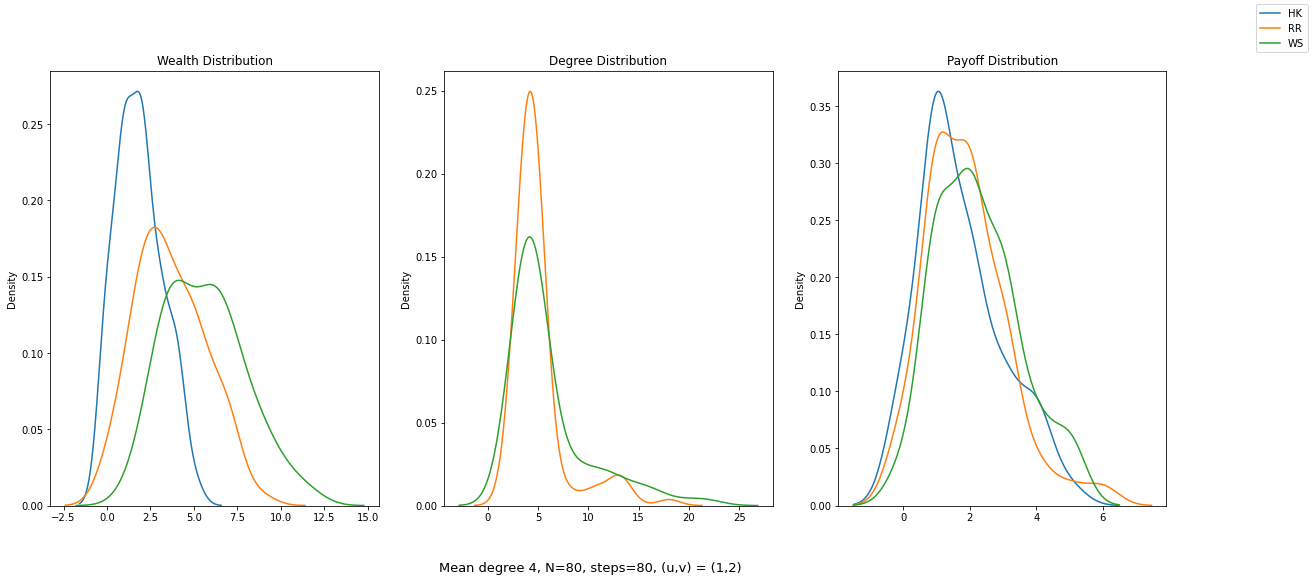

In [30]:
#Compare different networks endstates with each other.
from scipy.optimize import curve_fit
from itertools import chain
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 8))



for i in range(3):
    if i == 0:
        sns.kdeplot(Wealth[i],   ax=ax[0], label='HK' )
        sns.kdeplot(Degrees[i],   ax=ax[1], label='HK')
        sns.kdeplot(Payoffs[i],  ax=ax[2], label='HK')
    if i == 1:
        sns.kdeplot(Wealth[i],   ax=ax[0], label='RR')
        sns.kdeplot(Degrees[i],  ax=ax[1], label='RR')
        sns.kdeplot(Payoffs[i],  ax=ax[2], label='RR')
    if i == 2:
        sns.kdeplot(Wealth[i],   ax=ax[0], label='WS')
        sns.kdeplot(Degrees[i],   ax=ax[1], label='WS')
        sns.kdeplot(Payoffs[i],  ax=ax[2], label='WS')
#create legend indicating network type
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')


ax[0].set_title('Wealth Distribution')
ax[1].set_title('Degree Distribution')
ax[2].set_title('Payoff Distribution')
#provide list of parameters below plot
plt.figtext(0.5, 0.01, "Mean degree 4, N=80, steps=80, (u,v) = (1,2)", ha="center", fontsize=13)
plt.show()


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_85337/3336055776.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')


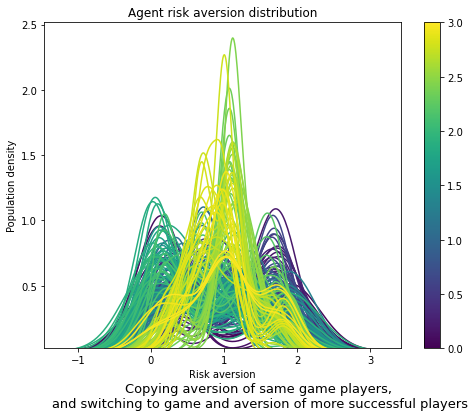

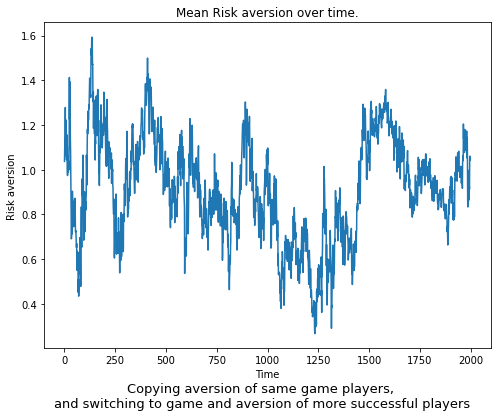

In [127]:
#copy system dynamics plots for risk aversion

plt.figure(figsize=(8,6))
for i in range(len(RiskAv)):
    #temp = degrees.loc[i, :].values.tolist()[0]
    #print(len(degrees))
    if i%10 == 0:
        #choose viridis as colormap
        cmap = plt.cm.get_cmap('viridis')
        #print(degrees[i])
        #temp4 = range(len(degrees[i]))
        #plt.loglog(temp4, degrees[i], c = cmap(i/len(degrees)))
        
        sns.kdeplot(RiskAv[i], fill=False, color = cmap(i/len(RiskAv))) #, log_scale=(True, True)

        #plt.hist(temp, bins=10, weights=None, color="green",edgecolor="black")
        #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        
normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
#lower limit for y axis 

plt.gca().set_ylim(bottom=1/len(RiskAv[i]))


plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
plt.title("Agent risk aversion distribution")
plt.xlabel("Risk aversion")
plt.ylabel("Population density")
plt.figtext(0.5, -0.01, "Copying aversion of same game players, " "\n" "and switching to game and aversion of more successful players", ha="center", fontsize=13)
plt.show()
#print one agents risk aversion over time
plt.figure(figsize=(8,6))
# return list of entries in RiskAv for one agent
temp = [np.mean(x) for x in RiskAv]

plt.plot(temp)


plt.title("Mean Risk aversion over time.")
plt.xlabel("Time")
plt.ylabel("Risk aversion")
plt.figtext(0.5, -0.01, "Copying aversion of same game players," "\n" " and switching to game and aversion of more successful players", ha="center", fontsize=13)

plt.show()
 


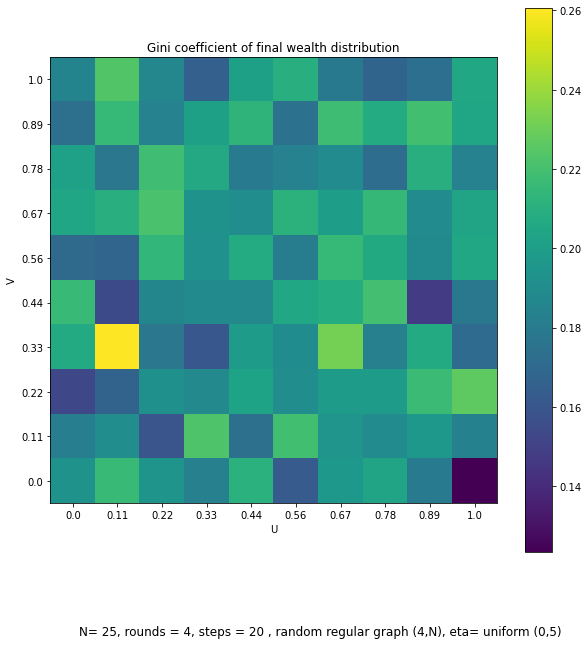

In [53]:
#plot heatmap
import matplotlib.pyplot as plt
#plot heatmap
plt.imshow(heat_map, interpolation='nearest', cmap=plt.cm.viridis )
#add colorbar to heatmap
plt.colorbar()
#rescale axis 
plt.xticks(np.arange(0,10,1),np.round(U,2))
plt.yticks(np.arange(0,10,1),np.round(V,2))
#reverse y axis
plt.gca().invert_yaxis()
#smooth heatmap 
plt.gcf().set_size_inches(10, 10)
#label axis
plt.xlabel('U')
plt.ylabel('V')
#add description
plt.title('Gini coefficient of final wealth distribution')
#add description below
plt.figtext(0.5, 0.01, 
f'N= {N_AGENTS}, rounds = {N_ROUNDS}, steps = {N_STEPS} , random regular graph (4,N), eta= uniform (0,5)', wrap=True, horizontalalignment='center', fontsize=12)





plt.show()

In [ ]:
#Estimate error for heatmap
data = np.array(data)
#for every entry in data shuffle array
def error_heatmap(data):
    heatmap = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):
        for j in range(len(data[i])):
            np.random.shuffle(data[i][j])


    for i in range(len(data)):
        for j in range(len(data[i])):
            temp = np.array(data[i][j])
            temp1 = temp[:int(len(temp)/2)]
            temp2 = temp[int(len(temp)/2):]
            heatmap[i][j] = (np.abs(gini_new(temp1) - gini_new(temp2)))
    
    return heatmap

#average multiple runs of error_heatmap
def average_error_heatmap(data, runs):
    heatmap = error_heatmap(data)
    for i in range(runs-1):
        heatmap = np.add(heatmap, error_heatmap(data))
    heatmap = np.divide(heatmap, runs)
    return heatmap

heatmatrix = average_error_heatmap(data, 100)
#divide average_error_heatmap by heatmap to get relative error
heatmatrix = np.divide(heatmatrix, heat_map)




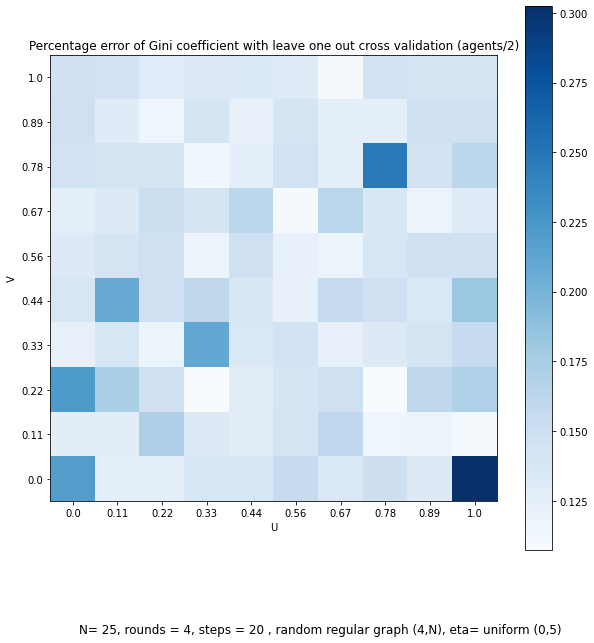

In [55]:
#plot heatmap
import matplotlib.pyplot as plt
#plot heatmap
plt.imshow(heatmatrix, interpolation='nearest', cmap=plt.cm.Blues )
#add colorbar to heatmap
plt.colorbar()
#rescale axis 
plt.xticks(np.arange(0,10,1),np.round(U,2))
plt.yticks(np.arange(0,10,1),np.round(V,2))
#reverse y axis
plt.gca().invert_yaxis()
#smooth heatmap 
plt.gcf().set_size_inches(10, 10)
#label axis
plt.xlabel('U')
plt.ylabel('V')
#add description
plt.title('Percentage error of Gini coefficient with leave one out cross validation (agents/2)')
#add description below
plt.figtext(0.5, 0.01, 
f'N= {N_AGENTS}, rounds = {N_ROUNDS}, steps = {N_STEPS} , random regular graph (4,N), eta= uniform (0,5)', wrap=True, horizontalalignment='center', fontsize=12)





plt.show()

/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_65107/3603293025.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_65107/3603293025.py:63: UserWarning: Dataset has 0 variance

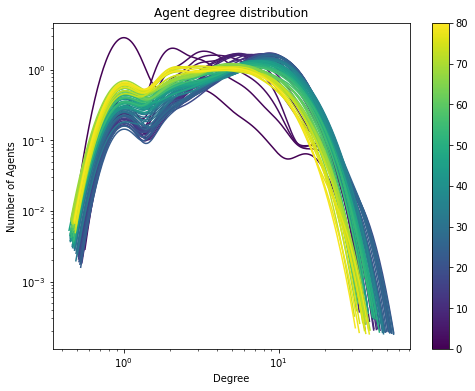

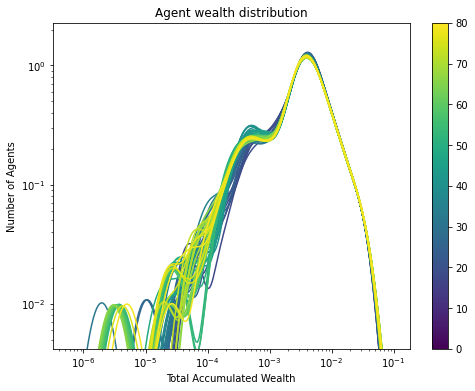

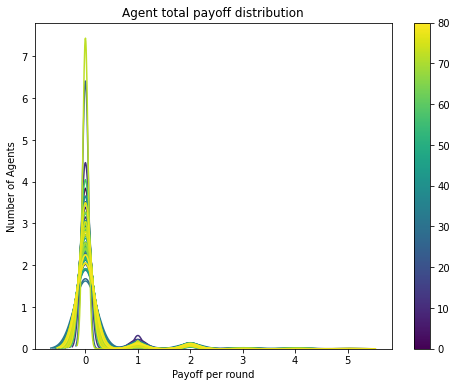

In [4]:
#system dynamics plots
from scipy.optimize import curve_fit
from itertools import chain
import matplotlib as mpl
import matplotlib.pyplot as plt

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def c_exponent(kde):
    kde_fit = kde.get_lines()[0].get_data()
    max_value = max(kde_fit[1])
    #extract all entries after the maximum value
    max_index = kde_fit[1].tolist().index(max_value)
    #extract the corresponding x values
    max_x = kde_fit[1][max_index:]
    x1  = kde_fit[0][max_index:]
    #x2  = x1 - min(x1)
    p0 = 1, 1, -2  

    #print(max_x, x)


In [ ]:

    popt, pcov = curve_fit(func, x1, max_x, p0) 
    result = func(x1, *popt)
    return(x1, result)

    

#degrees = simulateANDdegree(N=100, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = 5, steps = 500)
plt.figure(figsize=(8,6))
for i in range(len(Degrees)):
    #temp = degrees.loc[i, :].values.tolist()[0]
    #print(len(degrees))
    if i%1 == 0:
        #choose viridis as colormap
        cmap = plt.cm.get_cmap('viridis')
        #print(degrees[i])
        #temp4 = range(len(degrees[i]))
        #plt.loglog(temp4, degrees[i], c = cmap(i/len(degrees)))
        kde_degree = sns.kdeplot(Degrees[i], fill=False, color = cmap(i/len(Degrees)), log_scale=(True, True)) #

        #plt.hist(temp, bins=10, weights=None, color="green",edgecolor="black")

normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')


plt.title("Agent degree distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Agents")


plt.figure(figsize=(8,6))
for i in range(len(Wealth)):
    #temp = degrees.loc[i, :].values.tolist()[0]
    #print(len(degrees))
    if i%1 == 0:
        #choose viridis as colormap
        cmap = plt.cm.get_cmap('viridis')
        #print(degrees[i])
        #temp4 = range(len(degrees[i]))
        #plt.loglog(temp4, degrees[i], c = cmap(i/len(degrees)))
        w = [ x / sum(Wealth[i]) for x in Wealth[i] ]
        sns.kdeplot(w, fill=False, color = cmap(i/len(Wealth)), log_scale=(True, True))

        #plt.hist(temp, bins=10, weights=None, color="green",edgecolor="black")
        #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        
normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
#lower limit for y axis 

plt.gca().set_ylim(bottom=1/len(Wealth[i]))


plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
plt.title("Agent wealth distribution")
plt.xlabel("Total Accumulated Wealth")
plt.ylabel("Number of Agents")


plt.figure(figsize=(8,6))
for i in range(len(Payoffs)):
    #temp = degrees.loc[i, :].values.tolist()[0]
    #print(len(degrees))
    if i%1 == 0:
        #choose viridis as colormap
        cmap = plt.cm.get_cmap('viridis')
        #print(degrees[i])
        #temp4 = range(len(degrees[i]))
        #plt.loglog(temp4, degrees[i], c = cmap(i/len(degrees)))
        #print(Payoffs[i])
        sns.kdeplot(Payoffs[i], fill=False, color = cmap(i/len(Payoffs))) #, log_scale=(True, True)
        #plt.hist(temp, bins=10, weights=None, color="green",edgecolor="black")
        #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#print(Payoffs)
normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
plt.title("Agent total payoff distribution")
plt.xlabel("Payoff per round")
plt.ylabel("Number of Agents")




plt.show()

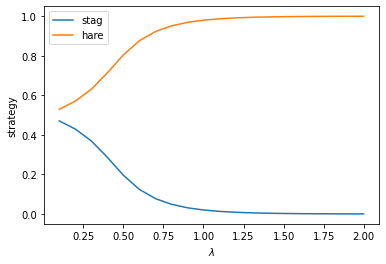

In [12]:
from sympy import symbols, Eq, solve, exp 
import sgamesolver
import numpy as np

payoff_matrix = np.array([[[10, 1],
                        [8, 5]],
                        [[10, 8],
                        [1, 5]]])
game = sgamesolver.SGame.one_shot_game(payoff_matrix=payoff_matrix)
game.action_labels = ['stag', 'hare']

homotopy = sgamesolver.homotopy.QRE(game)
homotopy.solver_setup()
homotopy.solver.verbose = 0 

lambdas = np.arange(0.1, 2.1, 0.1)
strategies = np.zeros(shape=(len(lambdas), 2), dtype=np.float64)

for idx, lambda_ in enumerate(lambdas):
    homotopy.solver.t_target = lambda_
    homotopy.solve()
    strategies[idx] = homotopy.equilibrium.strategies[0, 0]  # state_0, player_0

import matplotlib.pyplot as plt
plt.plot(lambdas, strategies[:, 0], label='stag')
plt.plot(lambdas, strategies[:, 1], label='hare')
plt.xlabel(r'$\lambda$')
plt.ylabel('strategy')
plt.legend()
plt.show()

# ratio = [ 2, 4, 3, 2]
# u11 = 8
# u12 = 4
# u21 = 4
# u22 = 2

# x, y = symbols('x y')
# eq1 = Eq(((2*(y*u11 + (1-y)*u12))), x) #/((exp(ratio[1]*(y*u11 + (1-y)*u12)))+(exp(ratio[1]*(y*u21 + (1-y)*u22))))
# eq2 = Eq(((4*(x*u11 + (1-x)*u21))), y) #/((exp(ratio[2]*(x*u11 + (1-x)*u21)))+(exp(ratio[2]*(x*u12 + (1-x)*u22))))



# sol_dict = solve((eq1,eq2), (x, y))
# print(sol_dict)
#print(f'x = {sol_dict[x]}')
#print(f'y = {sol_dict[y]}')

/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_4755/1037860195.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_4755/1037860195.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_4755/1037860195.py:53: MatplotlibDepr

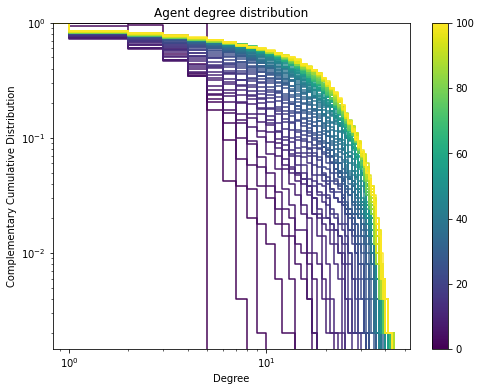

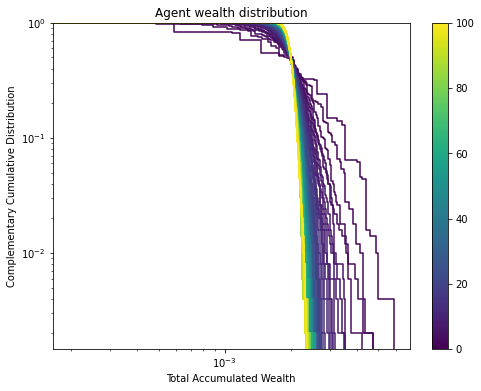

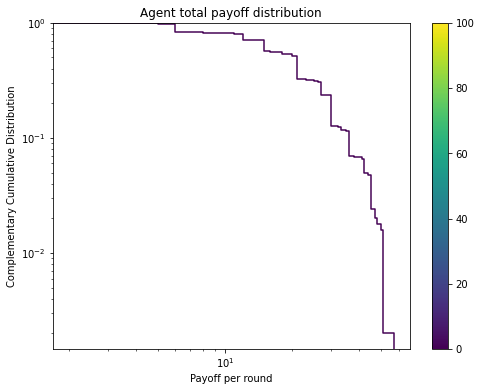

In [22]:
#Plot CCDF of results


import matplotlib.pyplot as plt
import matplotlib as mpl
#degrees = simulateANDdegree(N=100, netRat = 0.1, partScaleFree = 1, alwaysSafe = False, rounds = 5, steps = 500)
plt.figure(figsize=(8,6))
for i in range(len(Degrees)):

    if i%1 == 0:
        cmap = plt.cm.get_cmap('viridis')
        input1 = [float(a) for a in Degrees[i]]
        ccdf = sns.ecdfplot(input1, color = cmap(i/len(Wealth)), complementary=True, log_scale=(True, True))

normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')


plt.title("Agent degree distribution")
plt.xlabel("Degree")
plt.ylabel("Complementary Cumulative Distribution")


plt.figure(figsize=(8,6))
for i in range(len(Wealth)):

    if i%1 == 0:
        
        cmap = plt.cm.get_cmap('viridis')
        w = [ x / sum(Wealth[i]) for x in Wealth[i] ]
        input1 = [float(a) for a in w]
        ccdf = sns.ecdfplot(input1, color = cmap(i/len(Wealth)), complementary=True, log_scale=(True, True))
        #sns.kdeplot(w, fill=False, color = cmap(i/len(Wealth)), log_scale=(True, True))

        
normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
plt.title("Agent wealth distribution")
plt.xlabel("Total Accumulated Wealth")
plt.ylabel("Complementary Cumulative Distribution")


plt.figure(figsize=(8,6))
for i in range(len(Payoffs)):

    if i%99 == 0:

        cmap = plt.cm.get_cmap('viridis')

        input1 = [float(a) for a in Payoffs[i]]
        ccdf = sns.ecdfplot(input1, color = cmap(i/len(Wealth)), complementary=True, log_scale=(True, True))
normalizer = mpl.colors.Normalize(vmin = 0, vmax = len(Degrees))
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm = normalizer), orientation='vertical')
plt.title("Agent total payoff distribution")
plt.xlabel("Payoff per round")
plt.ylabel("Complementary Cumulative Distribution")




plt.show()

In [102]:
# Exponent fitting function (problem!)
# 
def c_exponent1(data):
    #kde_fit = kde.get_lines()[0].get_data()
    #print(kde_fit)
    middle_index = int(len(data)/2)
    half_kde_fit = data[middle_index:]
    #max_index = half_kde_fit.tolist().index(max(half_kde_fit)) 
    min_index = half_kde_fit.index(max(half_kde_fit)) + middle_index
    print(min_index)
    # max_x = kde_fit[1][_index:]
    # x1  = kde_fit[0][max_index:]
    results_truncated = powerlaw.Fit(data, xmin=min_index, discrete=True)

    
    #p0 = 1, 1, -2  

    #popt, pcov = curve_fit(func, x1, max_x, p0) 
    #result = func(x1, *popt)
    return(results_truncated)

temp = []
for i in range(1):
    #sample from exponential distribution
    #temp.append([rand.expovariate(4) for i in range(1000)])
    #sample from uniform distribution
    #temp.append([rand.uniform(0, 1) for i in range(1000)])
    #sample from powerlaw distribution
    #temp.append(powerlaw.Power_Law(xmin=1, parameters=[2]).generate_random(1000))
    #sample from lognormal distribution
    temp.append([rand.lognormvariate(0, 1) for i in range(1000)])
    #print(temp)
temp=temp[0]

G = nx.powerlaw_cluster_graph(100, 4, 0.1)
degrees = list(dict(G.degree()).values())
print(degrees)
fit = c_exponent1(degrees)
fit.power_law.plot_pdf(color='g', linestyle='--')
fit.lognormal.plot_pdf(color='r', linestyle='--')

powerlaw.plot_pdf(degrees , color='r')
fit.plot_pdf(color='g')

In [30]:
N = 100
graph = nx.powerlaw_cluster_graph(N,1,0.5)
#mean degree of graph
print(sum(dict(graph.degree()).values())/N)

graph2 = nx.random_regular_graph(2, N)
print(sum(dict(graph2.degree()).values())/N)

1.98
2.0


In [123]:
import random as random
x = [2, 3,  4, 10]

#normalize x
xy = [float(i)/sum(x) for i in x]

#choose a entry of x based on weight of x
k= np.random.choice(x, p = xy)
k= random.choices(x, weights=xy, k=1)
print(k)


4


In [4]:
test = [[[1,1],[1,1],], [[1, 1],[1, 1]]]
P0 = UP = LEFT = RISK = 0
P1 = DOWN = RIGHT = SAFE = 1
N=29
import numpy as np
UV = np.random.RandomState(42).rand(N,2)*3 - 1
game_l = [None] * N
for i in range(N):
    game_l[i] = [[1,UV[i][0]],[UV[i][1],0]]
game_list = game_l

print(game_list[0])
print(test[0])
     
payoffs = [list(zip(game_list[LEFT], test[LEFT])) ,list(zip(game_list[RIGHT], test[RIGHT]))]
print(payoffs)

[[1, 0.12362035654208747], [1.8521429192297485, 0]]
[[1, 1], [1, 1]]
[[([1, 0.12362035654208747], [1, 1]), ([1.8521429192297485, 0], [1, 1])], [([1, 1.1959818254342154], [1, 1]), ([0.7959754525911098, 0], [1, 1])]]


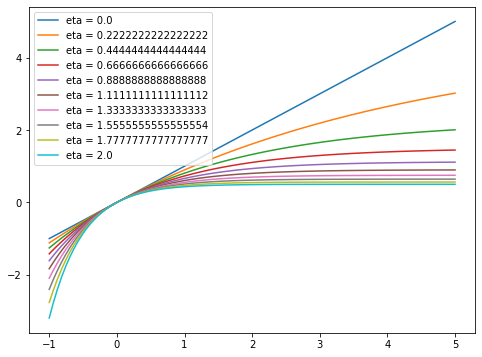

In [67]:
import matplotlib.pyplot as plt
def utilityFunct(self, eta, c):
    'The implemented utility function is the isoelastic utility function.'

    if eta != 0:
        return (1- np.exp(-eta*c))/(eta)
    else:
        return c

 

# plot the utility function for c in [0, 5] and eta in [0, 5]
c = np.linspace(-1, 5, 100)
eta = np.linspace(0, 2, 10)
#c, eta = np.meshgrid(c, eta)
u = np.zeros((len(eta), len(c)))
for i in range(len(eta)):
    for j in range(len(c)):
        u[i][j] = utilityFunct(0, eta[i], c[j])

#plot u rows as a function of c
#plot figure size
plt.figure(figsize=(8,6))
for i in range(len(eta)):
    plt.plot(c, u[i], label = 'eta = ' + str(eta[i]))
plt.legend()
plt.show()







In [37]:
# create power_cluster network, watts_strogatz network, random_regular network
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random as random
import math

# create power_cluster network
N = 100
n1 = 4
n2 = 1
n3 = 1
graph = nx.powerlaw_cluster_graph(N,int(n1/2),n3)
#sum of all degrees
mean_degree1 = sum(dict(graph.degree()).values())/N

# create watts_strogatz network
graph2 = nx.watts_strogatz_graph(N, n1, n2)
mean_degree2 = sum(dict(graph2.degree()).values())/N

# create random_regular network
graph3 = nx.random_regular_graph(n1, N)
mean_degree3 = sum(dict(graph3.degree()).values())/N

print(mean_degree1, mean_degree2, mean_degree3)



3.92 4.0 4.0


In [42]:
UV= [True, 1, 1]
N=8

if UV[0]:
    uvpay = np.random.RandomState().rand(N,2)*3 - 1
    game_l = [None] * N
    for i in range(N):
        game_l[i] = [[1,uvpay[i][0]],[uvpay[i][1],0]]
    game_list = game_l
if not UV[0]:
    game_l = [None] * N
    for i in range(N):
        game_l[i] = [[1,UV[1]],[UV[2],0]]
    game_list = game_l
print(uvpay)
print(game_list)

[[ 1.57103877  0.16035595]
 [ 0.69474429  0.2229645 ]
 [ 0.7845076  -0.92601235]
 [-0.83638185 -0.14075977]
 [ 0.65654945  1.7614831 ]
 [ 1.5476541   0.6047236 ]
 [ 0.88201673  0.74793677]
 [-0.51875594 -0.44592618]]
[[[1, 1.5710387670444863], [0.16035595074412212, 0]], [[1, 0.6947442903605467], [0.2229645028407825, 0]], [[1, 0.7845076026918143], [-0.9260123457840919, 0]], [[1, -0.8363818459987521], [-0.14075977480287682, 0]], [[1, 0.6565494503169707], [1.7614831038318188, 0]], [[1, 1.5476541022469164], [0.604723595846453, 0]], [[1, 0.8820167271624255], [0.7479367668821395, 0]], [[1, -0.5187559407550886], [-0.4459261802508133, 0]]]


In [7]:
np.random.RandomState(42).rand(10,2)*3 - 1


array([[ 0.12362036,  1.85214292],
       [ 1.19598183,  0.79597545],
       [-0.53194408, -0.53201644],
       [-0.82574916,  1.59852844],
       [ 0.80334504,  1.12421773],
       [-0.93824652,  1.90972956],
       [ 1.49732792, -0.36298267],
       [-0.4545251 , -0.44978647],
       [-0.08727327,  0.57426929],
       [ 0.29583506, -0.12631258]])

In [42]:
alpha = 0.5
beta = 0.5
pay_diff = np.linspace(0, 2000, 10)
print(pay_diff)

limit = 600

#if elements in pay_diff are bigger than limit replace by limit
pay_diff[(alpha*(pay_diff-beta)) > limit] = limit
print(pay_diff)

P_con = 1/(1+np.exp(alpha*(pay_diff-beta)))
print("one", P_con)
P_con = np.nan_to_num(P_con)
print("two", P_con)
P_con = np.round(P_con, 4)
print("three", P_con)
P_con = P_con/np.sum(P_con)
print("four", P_con)
#print(sum(P_con))


[   0.          222.22222222  444.44444444  666.66666667  888.88888889
 1111.11111111 1333.33333333 1555.55555556 1777.77777778 2000.        ]
[   0.          222.22222222  444.44444444  666.66666667  888.88888889
 1111.11111111  600.          600.          600.          600.        ]
one [5.62176501e-001 7.13889816e-049 3.96906995e-097 2.20671537e-145
 1.22688508e-193 6.82121050e-242 6.61041994e-131 6.61041994e-131
 6.61041994e-131 6.61041994e-131]
two [5.62176501e-001 7.13889816e-049 3.96906995e-097 2.20671537e-145
 1.22688508e-193 6.82121050e-242 6.61041994e-131 6.61041994e-131
 6.61041994e-131 6.61041994e-131]
three [0.5622 0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
four [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


{1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99}
32


In [2]:
#